## Load Data

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

pretty_agg_names = {
    'fedavg': 'FedAvg',
    'rfa_whole': 'RFA Whole',
    'rfa_component': 'RFA Component',
    'random_sample_simple_0_3': 'Random Sample p = 0.3',
    'random_sample_simple_0_5': 'Random Sample p = 0.5',
    'random_sample_simple_0_7': 'Random Sample p = 0.7',
    'clusteragg_kmeans_3_average': 'KMeans K = 3 Average',
    'clusteragg_kmeans_5_average': 'KMeans K = 5 Average',
    'clusteragg_kmeans_8_average': 'KMeans K = 8 Average',
    'clusteragg_kmeans_3_median': 'KMeans K = 3 Median',
    'clusteragg_kmeans_5_median': 'KMeans K = 5 Median',
    'clusteragg_kmeans_8_median': 'KMeans K = 8 Median',
    'clusteragg_agglo_average': 'Agglomerative Average',
    'clusteragg_agglo_median': 'Agglomerative Median',
    # 'clusteragg_meanshift_average': 'ClusterAgg MeanShift Average',
    # 'clusteragg_meanshift_median': 'ClusterAgg MeanShift Median',
}

dirty_agg_names = {v:k for k,v in pretty_agg_names.items()}

pretty_client_names = {
        'no_poison_no_straggle': 'No Poison / No Straggle',
        'yes_poison_no_straggle': 'Yes Poison / No Straggle',
        'no_poison_yes_straggle': 'No Poison / Yes Straggle',
        'yes_poison_yes_straggle': 'Yes Poison / Yes Straggle',
    }

dirty_client_names = {v:k for k,v in pretty_client_names.items()}

pretty_weighting_names = {
    'ignore_delays': 'Ignore Delays',
    'no_staleness': 'No Staleness',
    'lambda_1000_gamma_1': '$\lambda = 1000$ $\gamma = 1$',
    'lambda_1000_gamma_0_7': '$\lambda = 1000$ $\gamma = 0.7$',
    'lambda_1000_gamma_0_5': '$\lambda = 1000$ $\gamma = 0.5$',
    'lambda_1000_gamma_0_2': '$\lambda = 1000$ $\gamma = 0.2$',
    'lambda_100_gamma_1': '$\lambda = 100$ $\gamma = 1$',
    'lambda_100_gamma_0_7': '$\lambda = 100$ $\gamma = 0.7$',
    'lambda_100_gamma_0_5': '$\lambda = 100$ $\gamma = 0.5$',
    'lambda_100_gamma_0_2': '$\lambda = 100$ $\gamma = 0.2$',
    'lambda_10_gamma_1': '$\lambda = 10$ $\gamma = 1$',
    'lambda_10_gamma_0_7': '$\lambda = 10$ $\gamma = 0.7$',
    'lambda_10_gamma_0_5': '$\lambda = 10$ $\gamma = 0.5$',
    'lambda_10_gamma_0_2': '$\lambda = 10$ $\gamma = 0.2$',
    'lambda_1_gamma_1': '$\lambda = 1$ $\gamma = 1$',
    'lambda_1_gamma_0_7': '$\lambda = 1$ $\gamma = 0.7$',
    'lambda_1_gamma_0_5': '$\lambda = 1$ $\gamma = 0.5$',
    'lambda_1_gamma_0_2': '$\lambda = 1$ $\gamma = 0.2$',
}


def get_report_path(agg_type:str, task_type:str, client_type:str, weighting_type:str = 'no_staleness') -> Path:
    # agg_name = agg_type + '' if not staleness else '_staleness'
    # staleness_lambda_str = str(staleness_lambda).replace('.','_')
    return Path(f'../output/{agg_type}/{task_type}/{client_type}/{weighting_type}/report.csv')

def get_result(agg_type:str = 'fedavg', task_type:str = 'mnist_0_1', weighting_type:str = 'no_staleness') -> pd.DataFrame:
    filenames = [
        get_report_path(agg_type, task_type, client_type, weighting_type)
        for client_type in pretty_client_names
    ]
    
    result_df = pd.DataFrame()
    if any([filename.is_file() for filename in filenames]):
        result_df = pd.concat([
            pd.read_csv(
                filename
            ).assign(**{
                "Client Type": client_type_name,
                "Aggregator Type": pretty_agg_names[agg_type],
                "Weighting Type": pretty_weighting_names[weighting_type],
                # "Staleness Lambda": staleness_lambda
            })
            for client_type, client_type_name in pretty_client_names.items()
            if (filename:=get_report_path(agg_type, task_type, client_type, weighting_type)).is_file()
        ]).rename(
            columns = dict(
                accuracy_score = 'Accuracy Score',
                round = 'Round',
                queue_size = '# Withheld Updates',
                aggregator_time = 'Aggregator Runtime',
                client_train_acc_avg = 'Client Training Accuracy',
                client_test_acc_avg = 'Client Test Accuracy'
            )
        )

    return result_df

mnist_results = pd.concat([
    get_result(agg_type, 'mnist_0_1', weighting_type)
    for agg_type in pretty_agg_names
    for weighting_type in pretty_weighting_names
])

cifar_results = pd.concat([
    get_result(agg_type, 'cifar_0_1', weighting_type)
    for agg_type in pretty_agg_names
    for weighting_type in pretty_weighting_names
])

figure_base_path = Path('../figures')
mnist_path = figure_base_path / 'mnist'
cifar_path = figure_base_path / 'cifar'

mnist_path.mkdir(parents=True,exist_ok=True)
cifar_path.mkdir(parents=True,exist_ok=True)

## MNIST comparison

### Average Based Aggregators

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_23901/1021698993.py:6: UserWarning: The palette list has more values (20) than needed (8), which may not be intended.
  grid = sns.relplot(


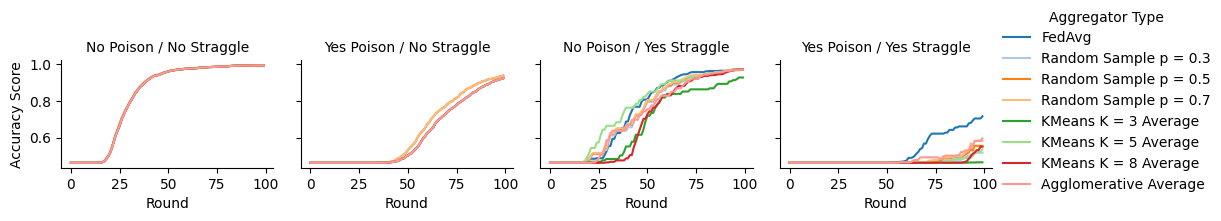

In [45]:
subset = mnist_results[
    (mnist_results['Aggregator Type'].str.contains('FedAvg|Average|Random Sample')) & 
    (mnist_results['Weighting Type'] == 'Ignore Delays')
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Accuracy Score',
    col = 'Client Type',
    hue = 'Aggregator Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    palette=sns.color_palette('tab20'),
    # col_wrap=2,
)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.2,0.6))
grid.figure.savefig(mnist_path / 'ignore_delays_average_based_compare.pdf', bbox_inches= 'tight')

### Median Based Aggregators

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_23901/510380940.py:6: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  grid = sns.relplot(


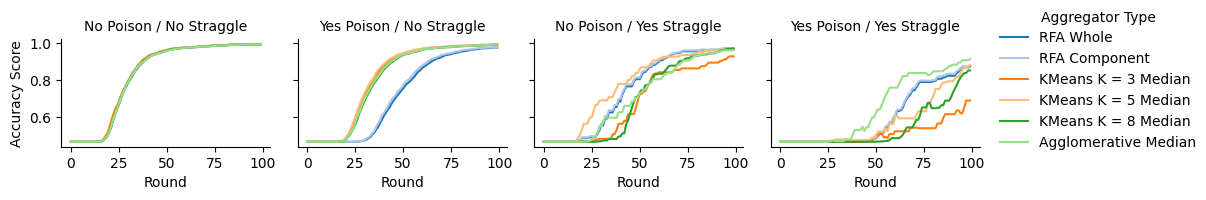

In [46]:
subset = mnist_results[
    (mnist_results['Aggregator Type'].str.contains('RFA|Median')) & 
    (mnist_results['Weighting Type'] == 'Ignore Delays')
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Accuracy Score',
    col = 'Client Type',
    hue = 'Aggregator Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    palette=sns.color_palette('tab20'),
    # col_wrap=2,
)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.2,0.6))
grid.figure.savefig(mnist_path / 'ignore_delays_median_based_compare.pdf', bbox_inches= 'tight')

### Just the clustering based

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_23901/3460430837.py:6: UserWarning: The palette list has more values (20) than needed (8), which may not be intended.
  grid = sns.relplot(


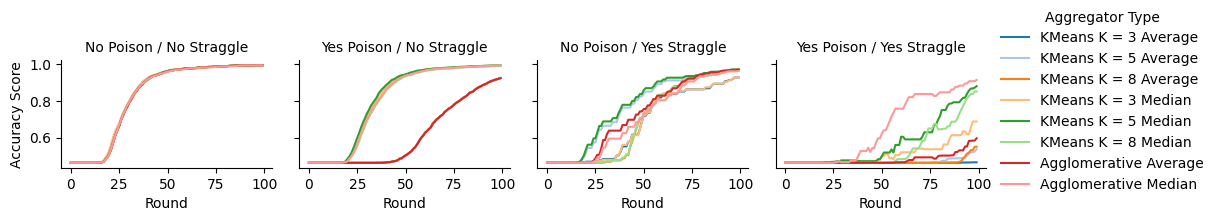

In [47]:
subset = mnist_results[
    (mnist_results['Aggregator Type'].str.contains('KMeans|Agglomerative')) & 
    (mnist_results['Weighting Type'] == 'Ignore Delays')
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Accuracy Score',
    col = 'Client Type',
    hue = 'Aggregator Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    # col_wrap=2,
    palette=sns.color_palette('tab20')
    
)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.2,0.6))
grid.figure.savefig(mnist_path / 'ignore_delays_cluster_based_compare.pdf', bbox_inches= 'tight')

### Compare the affect of staleness weighting

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_27383/3387756348.py:10: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  grid = sns.relplot(


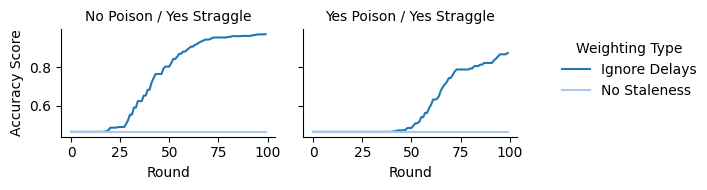

In [22]:
# for agg, subset in mnist_results.groupby('Aggregator Type'): 

agg = 'RFA Whole'
subset = mnist_results[
    (mnist_results['Aggregator Type'] == agg)\
    & (mnist_results['Client Type'].str.contains('Yes Straggle'))
    & (mnist_results['Weighting Type'].str.contains('Ignore Delays|No Staleness')) 
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Accuracy Score',
    col = 'Client Type',
    hue = 'Weighting Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    palette=sns.color_palette('tab20'),
    # col_wrap= 2,
)
# grid.figure.suptitle(agg)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.3,0.6))
grid.figure.savefig(mnist_path / f'compare_straggler_{dirty_agg_names[agg]}_no_stale.pdf', bbox_inches = 'tight')


    # break


#### Strange.. get rid of ignore delays

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_27383/3369630722.py:10: UserWarning: The palette list has more values (20) than needed (4), which may not be intended.
  grid = sns.relplot(


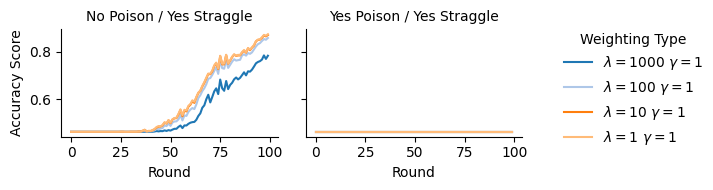

In [33]:
# for agg, subset in mnist_results.groupby('Aggregator Type'): 

agg = 'RFA Whole'
subset = mnist_results[
    (mnist_results['Aggregator Type'] == agg) &
    (mnist_results['Client Type'].str.contains('Yes Straggle')) &
    (mnist_results['Weighting Type'].str.contains('lambda'))
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Accuracy Score',
    col = 'Client Type',
    hue = 'Weighting Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    palette=sns.color_palette('tab20'),
    # col_wrap= 2,
)
# grid.figure.suptitle(agg)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.3,0.5))
grid.figure.savefig(mnist_path / f'compare_straggler_{dirty_agg_names[agg]}_weighting.pdf', bbox_inches = 'tight')

    # break


### Runtime Analysis

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_23901/1850701504.py:9: UserWarning: The palette list has more values (20) than needed (8), which may not be intended.
  grid = sns.relplot(


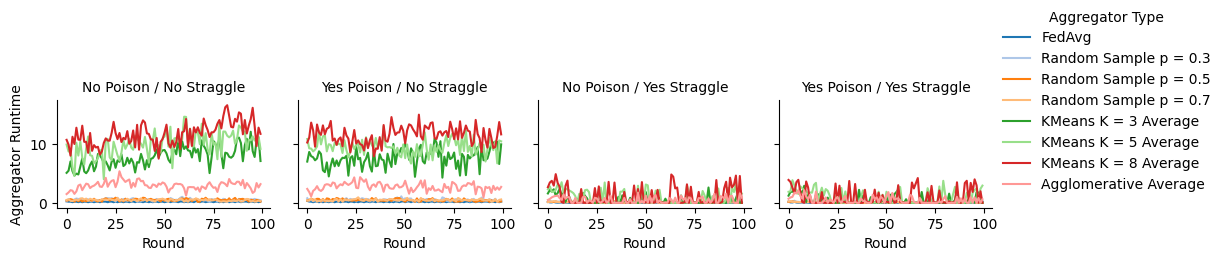

In [64]:
# for agg, subset in mnist_results.groupby('Aggregator Type'): 

# agg = 'FedAvg'
subset = mnist_results[
    (mnist_results['Weighting Type'] == 'Ignore Delays') &
    (mnist_results['Aggregator Type'].str.contains('FedAvg|Average|Random Sample'))
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Aggregator Runtime',
    col = 'Client Type',
    hue = 'Aggregator Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    palette=sns.color_palette('tab20'),
    # col_wrap= 2,
)
# grid.figure.suptitle(agg)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.2,0.8))
grid.figure.savefig(mnist_path / f'ignore_delays_average_based_runtime.pdf', bbox_inches = 'tight')

    # break


/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_23901/3157224074.py:9: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  grid = sns.relplot(


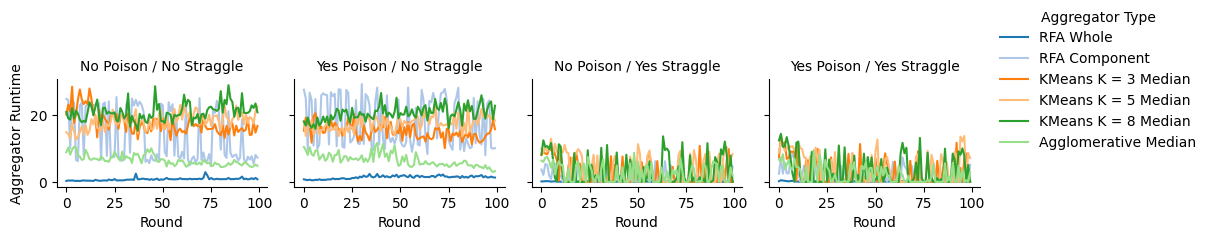

In [65]:
# for agg, subset in mnist_results.groupby('Aggregator Type'): 

# agg = 'FedAvg'
subset = mnist_results[
    (mnist_results['Weighting Type'] == 'Ignore Delays') &
    (mnist_results['Aggregator Type'].str.contains('RFA|Median'))
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Aggregator Runtime',
    col = 'Client Type',
    hue = 'Aggregator Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    palette=sns.color_palette('tab20'),
    # col_wrap= 2,
)
# grid.figure.suptitle(agg)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.2,0.8))
grid.figure.savefig(mnist_path / f'ignore_delays_median_based_runtime.pdf', bbox_inches = 'tight')

    # break


## CIFAR Comparison

### Average Based Aggregators

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_23901/393932221.py:6: UserWarning: The palette list has more values (20) than needed (8), which may not be intended.
  grid = sns.relplot(


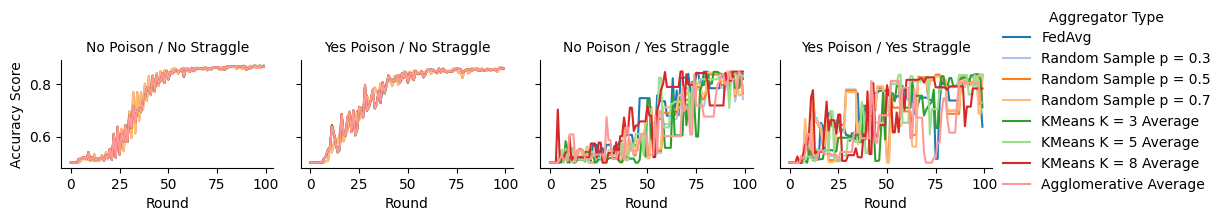

In [51]:
subset = cifar_results[
    (cifar_results['Aggregator Type'].str.contains('FedAvg|Average|Random Sample')) & 
    (cifar_results['Weighting Type'] == 'Ignore Delays')
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Accuracy Score',
    col = 'Client Type',
    hue = 'Aggregator Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    palette=sns.color_palette('tab20'),
    # col_wrap=2,
)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.2,0.6))
grid.figure.savefig(cifar_path / 'ignore_delays_average_based_compare.pdf', bbox_inches= 'tight')

### Median Based Aggregators

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_23901/2870912986.py:6: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  grid = sns.relplot(


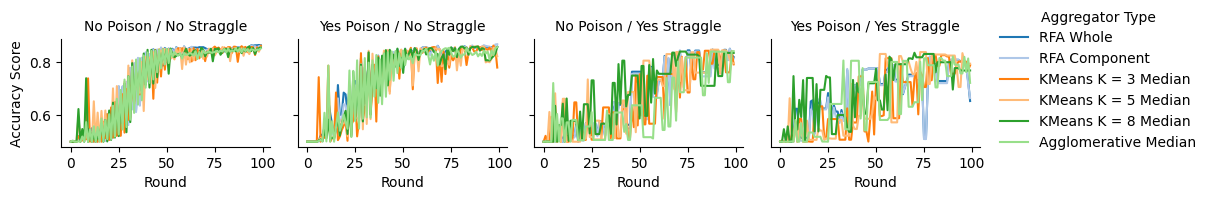

In [52]:
subset = cifar_results[
    (cifar_results['Aggregator Type'].str.contains('RFA|Median')) & 
    (cifar_results['Weighting Type'] == 'Ignore Delays')
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Accuracy Score',
    col = 'Client Type',
    hue = 'Aggregator Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    palette=sns.color_palette('tab20'),
    # col_wrap=2,
)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.2,0.6))
grid.figure.savefig(cifar_path / 'ignore_delays_median_based_compare.pdf', bbox_inches= 'tight')

### Cluster based only

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_23901/1756300722.py:6: UserWarning: The palette list has more values (20) than needed (8), which may not be intended.
  grid = sns.relplot(


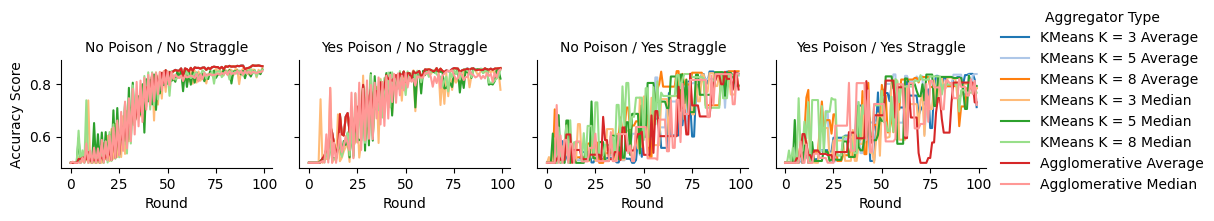

In [53]:
subset = cifar_results[
    (cifar_results['Aggregator Type'].str.contains('KMeans|Agglomerative')) & 
    (cifar_results['Weighting Type'] == 'Ignore Delays')
]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Accuracy Score',
    col = 'Client Type',
    hue = 'Aggregator Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    # col_wrap=2,
    palette=sns.color_palette('tab20')
    
)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.2,0.6))
grid.figure.savefig(cifar_path / 'ignore_delays_cluster_based_compare.pdf', bbox_inches= 'tight')

### Compare the affect of staleness weighting

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_23901/3299374465.py:6: UserWarning: The palette list has more values (20) than needed (5), which may not be intended.
  grid = sns.relplot(


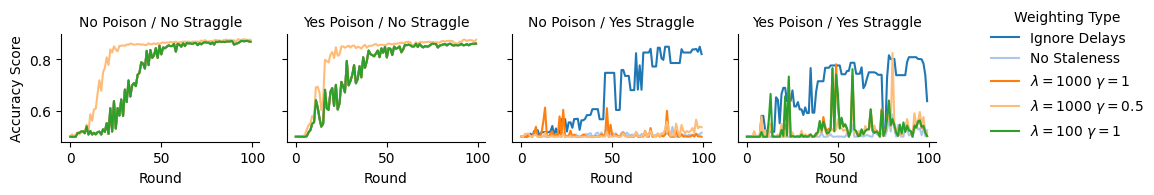

In [56]:
# for agg, subset in mnist_results.groupby('Aggregator Type'): 

agg = 'FedAvg'
subset = cifar_results[cifar_results['Aggregator Type'] == agg]

grid = sns.relplot(
    data = subset,
    x = 'Round',
    y = 'Accuracy Score',
    col = 'Client Type',
    hue = 'Weighting Type',
    kind = 'line',
    errorbar = None,
    height= 2,
    aspect = 1,
    palette=sns.color_palette('tab20'),
    # col_wrap= 2,
)
# grid.figure.suptitle(agg)
grid.set_titles('{col_name}')
grid.figure.tight_layout()
grid.legend.set_bbox_to_anchor((1.2,0.6))
grid.figure.savefig(cifar_path / f'compare_weighting_{dirty_agg_names[agg]}.pdf', bbox_inches = 'tight')

    # break
